In [3]:
import pandas as pd
pd.set_option('display.max_rows', 10000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt import gp_minimize
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import pandas as pd 
import random 

In [4]:
file = pd.ExcelFile('Indoor MPP_1.0 sun_Air_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl') 
sn = file.sheet_names  
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')  
temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy()  
temperature = temperature[2,2:]  
devices = data_frame.columns.to_numpy()  
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')  
time_series_df = time_series_df.drop(index =[0]) 
time = time_series_df.iloc[:,0]  
time_series_1_air_sun = []
for i in range (temperature.shape[0]):
    time_series_1_air_sun.append(time_series_df.iloc[:,3+i*3])  
time_series_1_air_sun = np.array(time_series_1_air_sun)  


file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl') 
sn = file.sheet_names  
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')  
temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy()  
temperature = temperature[2,2:]  
devices = data_frame.columns.to_numpy() 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:]  
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')  
time_series_df = time_series_df.drop(index =[0])  
time = time_series_df.iloc[:,0]  
 
time_series_1_sun = []
for i in range (temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:,3+i*3]) 
time_series_1_sun = np.array(time_series_1_sun) 


file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,3+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun)


outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')
irradiance = outdoor_conditions['irradiance']  
rh = outdoor_conditions['rh']  
outdoor_temperature = outdoor_conditions['outdoor_temperature']  
outdoor_condition_time = outdoor_conditions['time']  
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())


outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power)  

time_series_1_air_sun_shape = time_series_1_air_sun.shape
time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_air_sun = np.pad(time_series_1_air_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_air_sun.shape[1])),mode='edge') 
time_series_1_sun = np.pad(time_series_1_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])),mode='edge')    
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' ) 
time_series_1_air_sun = np.reshape(time_series_1_air_sun, ((time_series_1_air_sun.shape[0],time_series_1_air_sun.shape[1],1)))   
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0],time_series_1_sun.shape[1],1)))
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))

In [5]:
time_series_1_air_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_air_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_air_sun_average[j] = np.mean(time_series_1_air_sun[i-1:i+1], axis=0)
        j += 1

time_series_1_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i-1:i+1], axis=0)
        j += 1
 
time_series_1_4_sun_average = np.zeros((12, 4794, 1))
k = 0
for i in range(time_series_1_4_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_4_sun_average[k] = np.mean(time_series_1_4_sun[i-1:i+1], axis=0)
        k += 1

outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0 
        b += 1

outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 12, axis=0)
 

In [6]:
fourier_transform = np.fft.fft(time_series_1_sun_average, axis=1)
frequencies = np.fft.fftfreq(time_series_1_sun_average.shape[1])
magnitudes = np.abs(fourier_transform)
magnitudes_db = 20 * np.log10(magnitudes)
all_new_features = np.concatenate((time_series_1_4_sun_average,time_series_1_air_sun_average , outdoor_conditions_stacked[:, :, [2, 4]]), axis=2)

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Using GPU for computations.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU for computations.')

CUDA is not available. Using CPU for computations.


In [8]:
num_samples = all_new_features.shape[0]
all_new_features_reshaped = all_new_features.reshape(num_samples, -1)
outdoor_panels_power_average_reshaped = outdoor_panels_power_average.reshape(num_samples, -1)

num_folds = 12
average_mse_scores1 = []
average_mse_scores2 = []
fold = 0
y_pred1=np.zeros(( 1, 4794))

predictions1 = np.zeros((12, 1, 4794))
test1= np.zeros((12, 1, 4794))
predictions2 = np.zeros((12, 1, 4794))
test2 = np.zeros((12, 1, 4794))

 
for temp in range(6):
    test_index=[2*temp,2*temp+1]
    train_index = [i for i in range(num_samples) if i not in test_index]
    X_train, X_test = all_new_features_reshaped [train_index], all_new_features_reshaped [test_index]
    y_train, y_test = outdoor_panels_power_average_reshaped[train_index], outdoor_panels_power_average_reshaped[test_index]
    scaler = StandardScaler()
    X_train= scaler.fit_transform(X_train)
    X_test= scaler.transform(X_test)
    param_space = {
        'kernel': Categorical(['linear', 'rbf', 'poly']),
        'alpha': Real(0.001, 20.0, prior='log-uniform'),   
        'gamma': Real(0.0001, 20.0, prior='log-uniform'),   
        'degree': Integer(1, 5),   
        'coef0': Real(-2.0, 2.0),  
    }
    def objective_function(params):
        kernel = params[0]
        alpha = params[1]
        gamma = params[2]
        degree = params[3]
        coef0 = params[4]
        krr_model = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma, degree=degree, coef0=coef0)
        krr_model.fit(X_train, y_train)
        y_pred = krr_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse
    result = gp_minimize(
        objective_function,
        dimensions=list(param_space.values()),
        n_calls=100,   
        random_state=42,

        verbose=0
    )
    best_params = dict(zip(param_space.keys(), result.x))
    print("Best Hyperparameters for Fold {}: {}".format(fold + 1, best_params))
    best_krr_model = KernelRidge(**best_params)
    best_krr_model.fit(X_train, y_train)
    y_pred1 = best_krr_model.predict(X_test[0].reshape(1, -1))
    y_pred2 = best_krr_model.predict(X_test[1].reshape(1, -1))
    predictions1[fold] = y_pred1
    predictions2[fold] = y_pred2
    test1[fold] = y_test[0]
    test2[fold] = y_test[1]
    error1 = mean_squared_error(y_test[0].reshape(1, -1), y_pred1)
    error2= mean_squared_error(y_test[1].reshape(1, -1), y_pred2)
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error1))
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error2))
    average_mse_scores1.append(error1)
    average_mse_scores2.append(error2)
    fold = fold + 1
    if fold == 6:
        break


average_mse1 = np.mean(average_mse_scores1)
average_mse2 = np.mean(average_mse_scores2)
print(f"Average Mean Squared Error: {average_mse1}")
print(f"Average Mean Squared Error: {average_mse2}")

C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 1: {'kernel': 'poly', 'alpha': 19.998901544809602, 'gamma': 0.00010008951274631646, 'degree': 1, 'coef0': 2.0}
Fold 1 - Mean Squared Error: 0.6045764931992564
Fold 1 - Mean Squared Error: 0.2413700054685925


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 2: {'kernel': 'poly', 'alpha': 20.0, 'gamma': 0.0001, 'degree': 3, 'coef0': -1.289289142105845}
Fold 2 - Mean Squared Error: 1.8989359651954238
Fold 2 - Mean Squared Error: 0.5750643141341355


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 3: {'kernel': 'poly', 'alpha': 0.3987054116496063, 'gamma': 0.0001, 'degree': 1, 'coef0': 0.16388250478001476}
Fold 3 - Mean Squared Error: 1.565797010720553
Fold 3 - Mean Squared Error: 0.24848634903519673


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 4: {'kernel': 'rbf', 'alpha': 0.11256489593235393, 'gamma': 0.0007809713579551022, 'degree': 3, 'coef0': -2.0}
Fold 4 - Mean Squared Error: 0.47160685595774976
Fold 4 - Mean Squared Error: 0.2936052051853791


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 5: {'kernel': 'rbf', 'alpha': 0.14548732748703663, 'gamma': 0.00014443854917230018, 'degree': 5, 'coef0': 0.8728915948711071}
Fold 5 - Mean Squared Error: 0.14638232417051408
Fold 5 - Mean Squared Error: 0.5719867780499824


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 6: {'kernel': 'poly', 'alpha': 0.28707578421418894, 'gamma': 20.0, 'degree': 1, 'coef0': -0.7541476513212171}
Fold 6 - Mean Squared Error: 0.6313964713248873
Fold 6 - Mean Squared Error: 1.3843040398922635
Average Mean Squared Error: 0.8864491867613974
Average Mean Squared Error: 0.5524694486275916


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


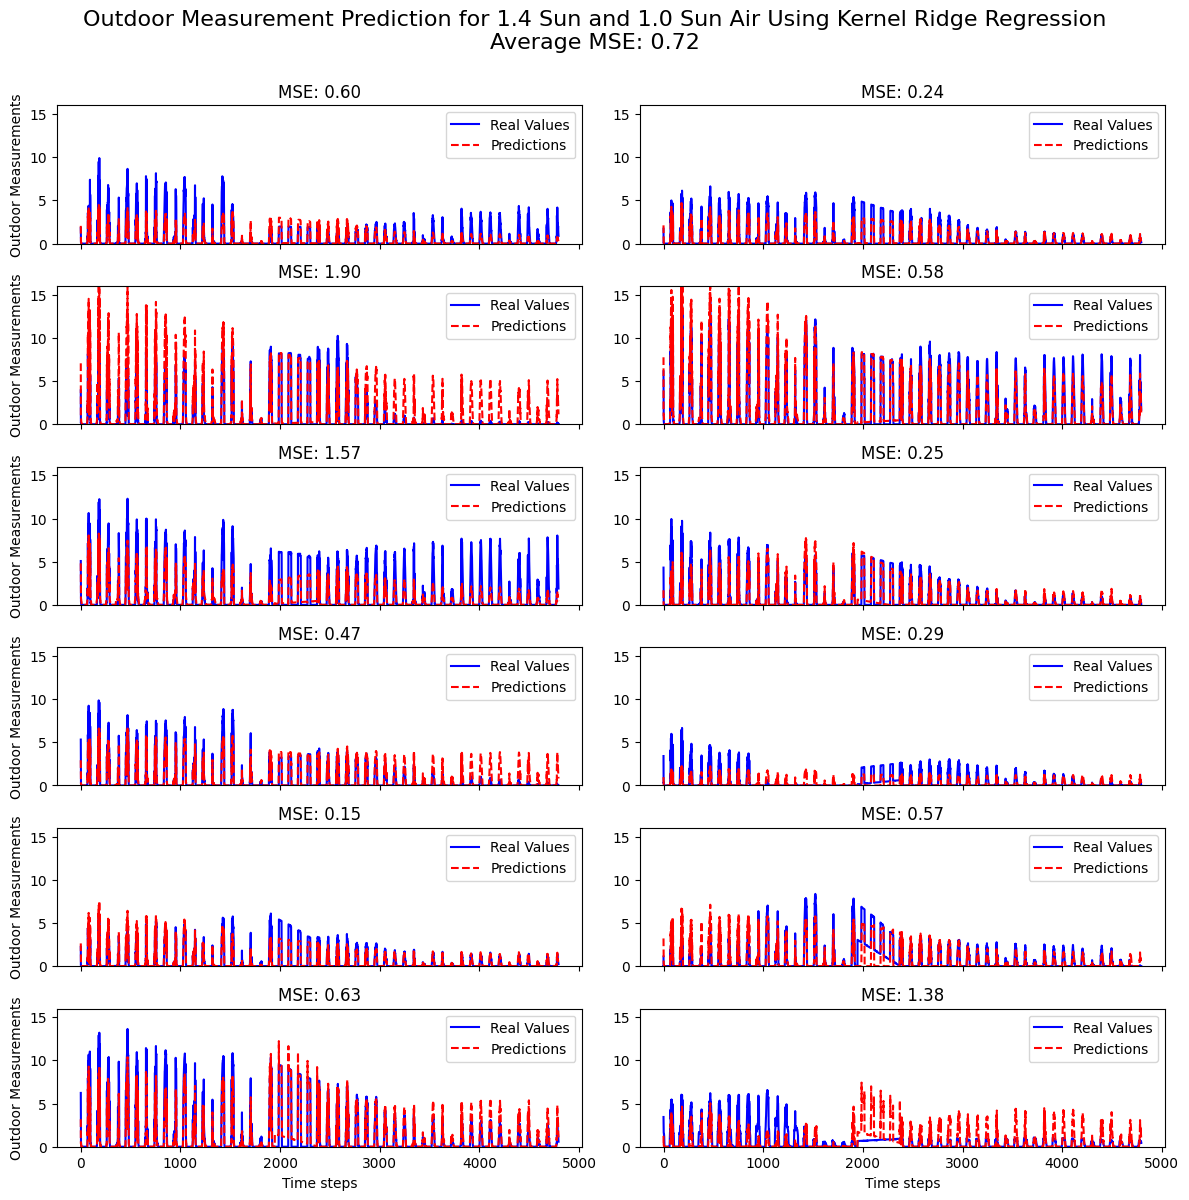

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 2, figsize=(12, 12), sharex=True)


for fold in range(6):
  
    y_pred_fold1 = predictions1[fold].squeeze()  
    y_pred_fold2 = predictions2[fold].squeeze()
    y_test_fold1 = test1[fold].squeeze()
    y_test_fold2 = test2[fold].squeeze()

    axes[fold, 0].plot(y_test_fold1, label='Real Values', color='blue')
    axes[fold, 0].plot(y_pred_fold1, label='Predictions', color='red',linestyle='dashed')
    axes[fold, 0].set_ylabel('Outdoor Measurements')
     
    axes[fold, 0].set_title(f'MSE: {average_mse_scores1[fold]:.2f}')
    axes[fold, 0].legend()
    axes[fold, 0].set_ylim(0, 16)
   
    axes[fold, 1].plot(y_test_fold2, label='Real Values', color='blue')
    axes[fold, 1].plot(y_pred_fold2, label='Predictions', color='red',linestyle='dashed')
     
    axes[fold, 1].set_title(f'MSE: {average_mse_scores2[fold]:.2f}') 
    axes[fold, 1].legend()
    axes[fold, 1].set_ylim(0, 16)

plt.tight_layout()
average_mse_all = (average_mse1+average_mse2)/2
axes[-1, 0].set_xlabel('Time steps')
axes[-1, 1].set_xlabel('Time steps')
fig.suptitle(f'Outdoor Measurement Prediction for 1.4 Sun and 1.0 Sun Air Using Kernel Ridge Regression\nAverage MSE: {average_mse_all:.2f}', fontsize=16)
fig.subplots_adjust(top=0.9)
plt.savefig('1.0 sun Air & 1.4 sun using krr.pdf')
plt.savefig('1.0 sun Air & 1.4 sun using krr.png')
plt.show()